# Neural Networks

In this tutorial, we'll move on from classical techniques and frameworks like sklearn, and start building deep learning models in pytorch. Since this tutorial is intended to be more of an introduction to deep learning for practitioners, I won't do much of a deep dive into the math and the theory. The focus will instead be on understanding what a neural network is, creating a basic neural network in pytorch, and how to train simple deep learning models. In later tutorials, we'll go into more specialized topics that touch on state of the art approaches, like convolutional neural networks for computer vision, and transformers for natural language processing.

So what is deep learning? In essense, **deep learning** is just a fancy rebrand from 15 or so years ago for neural networks. At the time neural nets weren't very well respected in the AI community, mostly because they didn't perform very well on the smaller datasets and limited compute available at the time. The term was chosen partly because of the growing tendency to use *deep* neural networks, i.e. networks with lots of hidden layers. Prior to that time, most neural networks had just a few hidden layers, maybe 1 to 5 tops. Starting with the release of Cuda, as well as a few algorithmic innovations to make training neural networks easier, they started to get a lot deeper, with some neural networks today even containing thousands of hidden layers.

So what is a neural network, then? Very roughly speaking, a **neural network** can be thought of as a fancy form of linear or logistic regression that contains a bunch of intermediate steps (called **layers**) designed to make linear or regression work better by transforming the problem to an easier space of features. These intermediate steps are thought of as "learned features". The term neural network itself comes from a loose analogy with the brain, which is sometimes believed to perform computations in a loosely similar way to the abstract neural nets we'll describe and use.

Once the neural network has "learned" all of these learned features, it's basically just going to apply vanilla linear or logistic regression to those learned features to make predictions in the usual way. The power of deep learning comes from the fact that, with enough data and compute, a neural net can *learn* the best features to make predictions on, rather than humans having to manually feature engineer them by hand. This idea that a model can take in raw inputs, learn the relevant features on its own, and make predictions is called **end-to-end learning**. 

As deep learning gets better and better, tasks that were once heavily feature engineered are getting more end-to-end, the most notable example being image classification. It used to be that images had to be heavily feature engineered before doing classification on them. Computer vision researchers spent decades coming up with fancy hand engineered features, like edge filters and SIFT features, to do image classification, because they thought such a task was far too complicated to do from raw images alone. Since the rise of deep learning, however, neural networks trained on raw images are doing far better on image classification tasks than any of these feature engineered approaches had managed to do, and it's become widely accepted that end-to-end deep learning is the best way to go when trying to classify images. This same trend has since happened to speech recognition, machine translation, text classification, language modeling, image generation, and many other areas as the years go by.

Before diving into more specifics of what neural networks are made of let's go ahead and import pytorch. The submodule of pytorch that contains everything relevant for deep learning is called `nn`, short for "neural networks". We'll import this submodule separately, along with its library of functions, usually just aliased to `F`. We'll also go ahead and set a device for those who'd prefer to work on the GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(123)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Linear Regression as a Neural Network

We already learned a bit about what linear regression is. Recall that linear regression tries to learn **parameters** $W,b$ to best fit each input-output pair $(x_i,y_i)$ in the dataset with a linear model defined by
$$\hat y_i = \hat y_i(W,b|x_i) = Wx_i + b.$$
It does this by minimizing the **mean squared error** loss function over all of the training data $i=1,\cdots,N$:
$$L(W,b) = \frac{1}{N} \sum_{i=1}^N \big(y_i - \hat y_i(W,b|x_i)\big)^2.$$
In deep learning lingo, this minimization procedure to find the best fit parameters $W,b$ is called **learning**, or **training** the model. The linear transformation $\hat y = Wx + b$ is called a **linear layer** or a **dense layer** of the neural network.

To get a linear layer in pytorch (with randomly initialized parameters) we just define an object `nn.Linear(num_features, num_targets)`, where `num_features` is the number of input features and `num_targets` is the number of target variables. We can pass the input data `X` through it just like we would any ordinary function.

Let's look at a simple example, where `num_features = num_targets = 1`, the simple kind you learn about in intro statistics classes. We'll generate some linear data `X, y` with light gaussian noise and then try to model it with a linear layer. Notice that:
- We can treat `model` just like any ordinary function that takes in data and outputs predictions.
- The predictions `yhat` are automatically part of the computational graph to calculate gradients, meaning we have make sure to detach it before converting it to a numpy array.
- The fit of the line is pretty poor. Not surprising, given we haven't actually *learned* anything yet. This model is just using randomly initialized values for `W` and `b`. They'll stay that way until we tune them with training.

In [3]:
num_features = 1
num_targets = 1
num_samples = 20

In [4]:
X = torch.linspace(0, 5, num_samples).reshape(-1, 1)
y = X + torch.randn(num_samples).reshape(-1, 1)
X.shape, y.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [5]:
model = nn.Linear(num_features, num_targets)
yhat = model(X)
yhat.shape

torch.Size([20, 1])

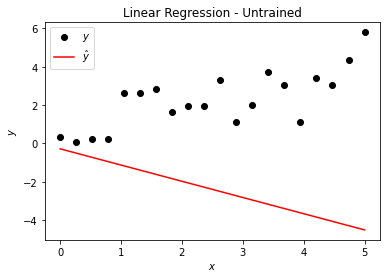

In [6]:
plt.scatter(X.numpy(), y.numpy(), label='$y$', color='black')
plt.plot(X.numpy(), yhat.detach().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Linear Regression - Untrained')
plt.show()

To actually access the parameter values themselves, we can use the `parameters` method of the `model` object. This will always be true for accessing neural net parameters in pytorch. By default, `model.parameters()` gives a python **generator** object, which we need to first convert into a list to get `[W, b]`. An easier way for linear layers is to just use `model.weight` to get the weights `W`, and `model.bias` to get the bias `b`. Notice that each parameter has `requires_grad=True` on, which makes sense, given that those are the things we want to learn. This will always be true.

In [7]:
params = list(model.parameters())
W = model.weight
b = model.bias
params, W, b

([Parameter containing:
  tensor([[-0.8457]], requires_grad=True),
  Parameter containing:
  tensor([-0.2869], requires_grad=True)],
 Parameter containing:
 tensor([[-0.8457]], requires_grad=True),
 Parameter containing:
 tensor([-0.2869], requires_grad=True))

## Gradient Descent

To actually learn the parameters that give the best fit we'll use an algorithm called **gradient descent**, which is the basis for just about every learning algorithm in deep learning. Gradient descent is a method for solving minimization problems that involves using the derivative (i.e. the gradient) of a function to find its minimum as quickly as possible. More formally, given a loss function $L(\theta)$ to minimize with respect to some parameters $\theta$, gradient descent seeks to find the minimum $\hat \theta$ by iteratively computing the update
$$\theta_{n+1} = \theta_n - \alpha \frac{dL(\theta_n)}{d\theta}$$
until convergence, i.e. until the difference $\Delta \theta_n \equiv \theta_{n+1} - \theta_n$ is "small enough". When doing deep learning in practice, rather than specify some convergence criterion like this, it's more typical to just run gradient descent for so many iterations and stop it when the loss doesn't seem to be decreasing much anymore.

The value $\alpha$ in the update is called the **learning rate**, or **step size**. It controls how big the update is at each step of the iteration, and is generally manually specified by the programmer before training starts. Since the learning rate controls the speed of learning, the goal is to make it as high as possible so the algorithm will converge quicker. Unfortunately though there are limits to this. If you make the learning rate too large the updates will spiral off to infinity or just oscillate forever and fail to converge. So there's an art to tuning the learning rate, by making it as big as you can but without making it too big.

Let's apply gradient descent to our above linear regression problem to see if we can learn the best fit line to the given data. Before training our linear regression model we need to know what function it is we're trying to minimize. In deep learning this will always be the loss function. For regression tasks, the loss function is usually the MSE loss defined above:
$$L(W,b) = \frac{1}{N} \sum_{i=1}^N \big(y_i - \hat y_i(W,b|x_i)\big)^2.$$

In pytorch, the loss is essentially just another layer that we can define and pass data through. To get the MSE loss we can just use the `nn.MSE` layer and then pass our predictions `yhat` through it to calculate the value. Note that in pytorch the order to pass arguments into the loss is always `yhat, y`, not the other way around.

In [8]:
loss_fn = nn.MSELoss()
loss = loss_fn(yhat, y)
loss

tensor(28.4925, grad_fn=<MseLossBackward0>)

Let's now try to minimize the loss function using gradient descent. Rather than code gradient descent from scratch, in pytorch it's better to define it as an **optimizer** object, and then step the optimizer until we're done training. The optimizer for gradient descent is called `torch.optim.SGD`, where SGD stands for **stochastic gradient descent**, which is a slight variation of gradient descent that works better for big datasets.

To use the optimizer object, we have to pass in the **parameters** we want to minimize, not the model itself. It's also here that we pass in the learning rate `lr` that'll be used for training the model. We'll just use `lr=0.1` here. There are also other values we can pass in to improve the optimization, but we won't go into these right now.

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Now everything is in place to begin training the model. What you're about to see is the standard backbone of training loops in pytorch. Some version of this loop is used to train the vast majority of deep learning models in pytorch.

Even though this example is simple enough that we don't need to, it's common to visualize training by printing out the value of the loss every few iterations. It's also common to plot the loss curve either during training or at the end of training.

We can see that the loss is indeed decreasing towards zero, which is exactly what we want here, since the MSE loss must always be a positive value (it's a sum of squares).

In [10]:
num_iters = 100
losses = []
for i in range(num_iters):
    opt.zero_grad()
    yhat = model(X)
    loss = loss_fn(yhat, y)
    loss.backward()
    opt.step()
    if i % 10 == 0:
        print(f'iter = {i} \t\t loss = {loss}')
    losses.append(loss.item())

iter = 0 		 loss = 28.492538452148438
iter = 10 		 loss = 2.3468408584594727
iter = 20 		 loss = 1.031928300857544
iter = 30 		 loss = 0.9647798538208008
iter = 40 		 loss = 0.9609823226928711
iter = 50 		 loss = 0.9606364965438843
iter = 60 		 loss = 0.9605627059936523
iter = 70 		 loss = 0.9605387449264526
iter = 80 		 loss = 0.9605301022529602
iter = 90 		 loss = 0.9605270624160767


Let's go ahead and look at the parameters again and see if we found our best fit line to the data. It certainly looks like they've updated. The plot shows a much better fit to the data as well.

In [11]:
W = model.weight
b = model.bias
W, b

(Parameter containing:
 tensor([[0.7272]], requires_grad=True),
 Parameter containing:
 tensor([0.4537], requires_grad=True))

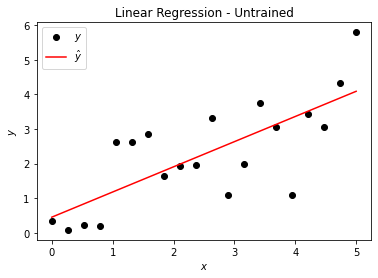

In [12]:
yhat = model(X)

plt.scatter(X.numpy(), y.numpy(), label='$y$', color='black')
plt.plot(X.numpy(), yhat.detach().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Linear Regression - Untrained')
plt.show()

Before moving onto logistic regression, it's worth showing how to actually implement a custom layer in pytorch. To do so we'll implement the above linear layer `nn.Linear` from scratch. In pytorch, a layer is any python class that
1. inherets from the nn.Module class,
2. implements a `forward` method that maps the layer input to the layer output.

Since we want parameters `W, b` that update with gradient descent, we need to keep track of their gradients, which means they need to have autodiff turned on. To play nice with the `nn` framework, the best way to do this for parameters is to wrap them inside `nn.Parameter`. This tells the layer that these are intended to be learnable parameters, and to keep track of them inside `model.parameters()`.

You always want to define your parameters inside the `__init__` method so that the layer object can keep track of them. The `forward` method is where the actual operation happens, which in this case is just the (vectorized) linear function
$$\hat y = WX + b.$$
Note that for linear layers the $WX$ is a *matrix multiply*, not an elementwise product. The bias vector $b$ is generally added to it directly using the standard numpy broadcasting rules. 

**Note:** There's always a question in deep learning of how to **initialize** the parameters at the beginning of training. There are a lot of ways to do this, and a lot of reasons for each, but for linear regression we'll be okay just initializing the weights using `torch.rand` and the bias using `torch.zeros`.

**Note:** We need to transpose the input and output vectors in `forward` due to the fact that we generally want to keep data in the format `(num_samples, num_features)` format. But the matrix multiply wants a `(num_features, num_samples)` format instead. An alternative that's often used is to not transpose the data, but to instead treat the feature vectors as row vectors and transpose the weight matrix $W$ instead:
$$\hat y = X W^T + b.$$

Once you've implemented a custom layer like this, it's always a good idea to first check that it works by passing some data through the layer and making sure things look reasonable. In this case, it looks like we're okay.

In [13]:
class Linear(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(num_targets, num_features))
        self.bias = nn.Parameter(torch.zeros(num_targets))
        
    def forward(self, X):
        X = X.T
        yhat = self.weight @ X + self.bias
        return yhat.T

In [14]:
linear = Linear(num_features, num_targets)
yhat = linear(X)
X.shape, y.shape, yhat.shape

(torch.Size([20, 1]), torch.Size([20, 1]), torch.Size([20, 1]))

## Logistic Regression

## Multilayer Perceptrons

There are many different types of neural network architectures. The simplest and oldest architecture is the **multilayer perceptron (MLP)**.